In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset


In [2]:
psd = xr.load_dataset('../../data/Processed/psd.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

### If training from scratch

In [3]:
''' Predictor with four inputs and four outputs '''
class Flux44(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,0,-8,-90]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,0.1,20.,50.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        pass

''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Flux44diff(Flux44):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  
    

In [ ]:
# import inspect
# import numpy as np  # Import NumPy

# def sample_weights(x):
#     return np.where(x > 18, 10.0, 1.0)

# function_string = inspect.getsource(sample_weights)
# function_definition = '\n'.join(function_string.split('\n')[1:])
# new_func = eval(function_definition)

# # Test the recreated function
# result = new_func(np.array([15, 20, 25]))
# print(result)

In [30]:
###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':4,'hidden_channels':[16,32,16]}
para2 = {'n_in':4,'n_out':4,'hidden_channels':[16,32,16]}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    training_data = RealFluxDataset(training_ds, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, weightfunc=sample_weights)

    ###### Run the model 5 times ######
    for run in range(5):   
        model = Flux44diff({'mean_ann_para':para1, 'var_ann_para':para2})
        model.datasplit = split
        training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2}
        log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
        # Later we can pick one before saving but since files are pretty small they are ok 
        model.save(fname="../../saved_model/full_anns_diff_3layers_split%g_run%g" %(i+1,run))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
training took 85.78 seconds, loss at last epoch -160.7910
training took 85.98 seconds, loss at last epoch -161.5347
training took 85.24 seconds, loss at last epoch -157.3133
training took 85.46 seconds, loss at last epoch -158.2103
training took 85.99 seconds, loss at last epoch -161.3749


In [35]:
###### Pick one out of five random weights initialization ######
import pickle

bestrun_list = []

for i in range(6):
    r2_validating_runs = []; r2_training_runs = []; loss_runs = []
    for run in range(5):
        with open('../../saved_model/full_anns_diff_split%g_run%g.p' %(i+1, run), 'rb') as pickle_file:
            model = pickle.load(pickle_file)
            r2_training_runs.append(model.log['training_r2'][-1])
            r2_validating_runs.append(model.log['validating_r2'][-1])
            loss_runs.append(model.log['LLLoss'][-1])
        
    r2_training_runs = np.array(r2_training_runs)
    r2_validating_runs = np.array(r2_validating_runs)
    # print(r2_training_runs, r2_validating_runs, loss_runs)
    
    # for ifeature in range(4):
    #     bestrun = r2_validating_runs[:,ifeature].argmax()
    #     print('Best run for feature %g is %g' %(ifeature,bestrun))
    
    ###### Pick best based on some metrics ######
    bestrun = r2_validating_runs[:,2].argmax()
    bestrun_list.append(bestrun)

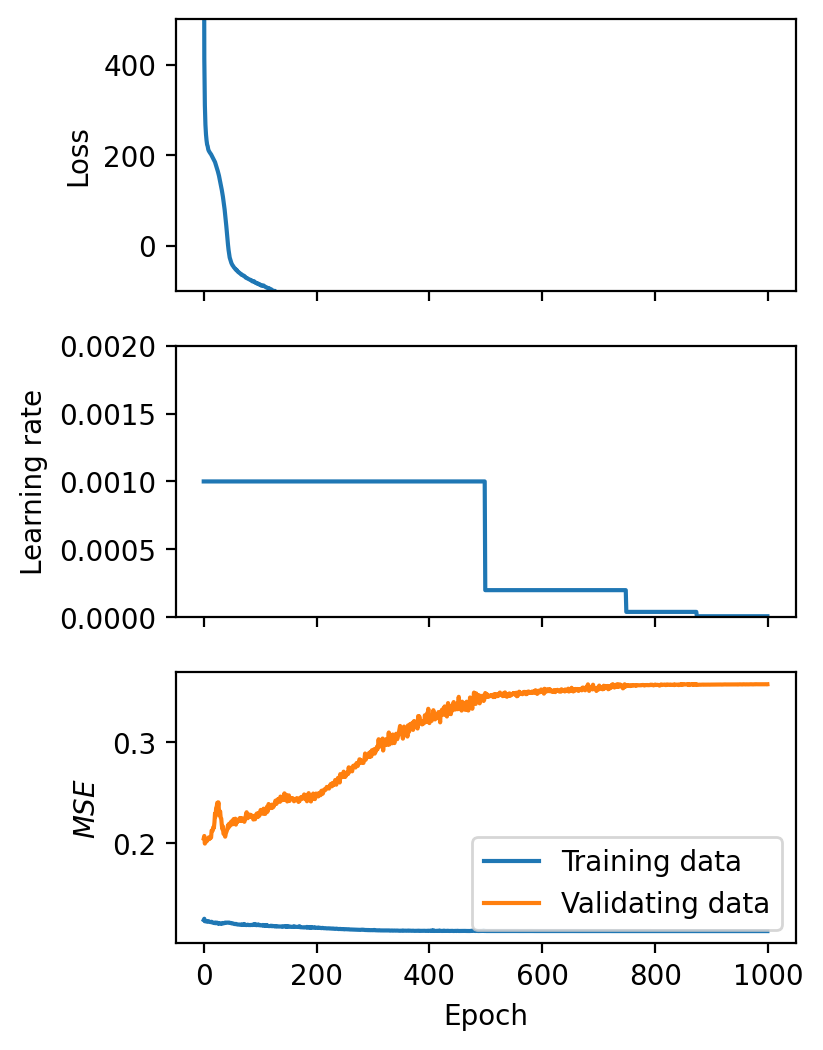

In [52]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)

i = 3
run = bestrun_list[i]
with open('../../saved_model/full_anns_diff_split%g_run%g.p' %(i+1,run), 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    log = model.log
           
log['training_mse'] = np.array(log['training_mse'])
log['training_r2'] = np.array(log['training_r2'])
log['validating_mse'] = np.array(log['validating_mse'])
log['validating_r2'] = np.array(log['validating_r2'])

axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
axes[0].set_ylim([-100,500])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.002])
axes[2].plot(log['training_mse'][:,1], label='Training data')
axes[2].plot(log['validating_mse'][:,1], label='Validating data')
axes[2].set_ylabel(r'$MSE$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
# axes[2].set_ylim([0,0.02])

### Save and some evaluations

In [36]:
###### Save ######
# model.save(fname="../../saved_model/full_anns_split1")
###### Load ######
import pickle
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)

# from mlflux.utils import mse_r2
def mse_r2(ypred, ytruth):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, axis=0)/np.var(ytruth, axis=0)
    return (mse,r2)

for i in range(6):
    run = bestrun_list[i]
    with open('../../saved_model/full_anns_diff_split%g_run%g.p' %(i+1,run), 'rb') as pickle_file:
        model = pickle.load(pickle_file)
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=model.datasplit, PLOT=False, XVIS='samples')
        ###### Initiate the Dataset class and use default weighting ######
        training_data = RealFluxDataset(training_ds, weightfunc=sample_weights)
        validating_data = RealFluxDataset(validating_ds, weightfunc=sample_weights)
        testing_data = RealFluxDataset(testing_ds, weightfunc=sample_weights)        
        model.metrics(validating_data.X, validating_data.Y)
        bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
        model.bulk_scores = {'mse':bulk_mse, 'r2':bulk_r2}
        print('NN r2' + str(model.scores['r2'].numpy()))
        print('Bulk r2' + str(model.bulk_scores['r2']))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068
NN r2[ 0.84074867 -0.21407402  0.59098583  0.6514373 ]
Bulk r2[ 0.87180203 -0.00589943  0.61994225  0.7058054 ]
Training samples: 8463
Validating samples: 1610
Testing samples: 1610
NN r2[ 0.3738715  -0.03160095  0.02133024  0.5981273 ]
Bulk r2[ 0.37037188 -0.00241661  0.01651227  0.519814  ]
Training samples: 7424
Validating samples: 2649
Testing samples: 2649
NN r2[0.51935697 0.00530005 0.37147588 0.37296522]
Bulk r2[ 0.4882151  -0.08457267  0.37613082  0.42167002]
Training samples: 9194
Validating samples: 879
Testing samples: 879
NN r2[ 0.8248024  -0.79951787  0.7322977   0.6400656 ]
Bulk r2[ 0.8757325  -0.03921318  0.76916194  0.6486793 ]
Training samples: 8826
Validating samples: 1247
Testing samples: 1247
NN r2[0.88060886 0.02692711 0.50187653 0.4105286 ]
Bulk r2[ 0.9252891  -0.09058702  0.44552886  0.32681102]
Training samples: 9453
Validating samples: 620
Testing samples: 620
NN r2[ 0.794151   -0.13351429  0

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


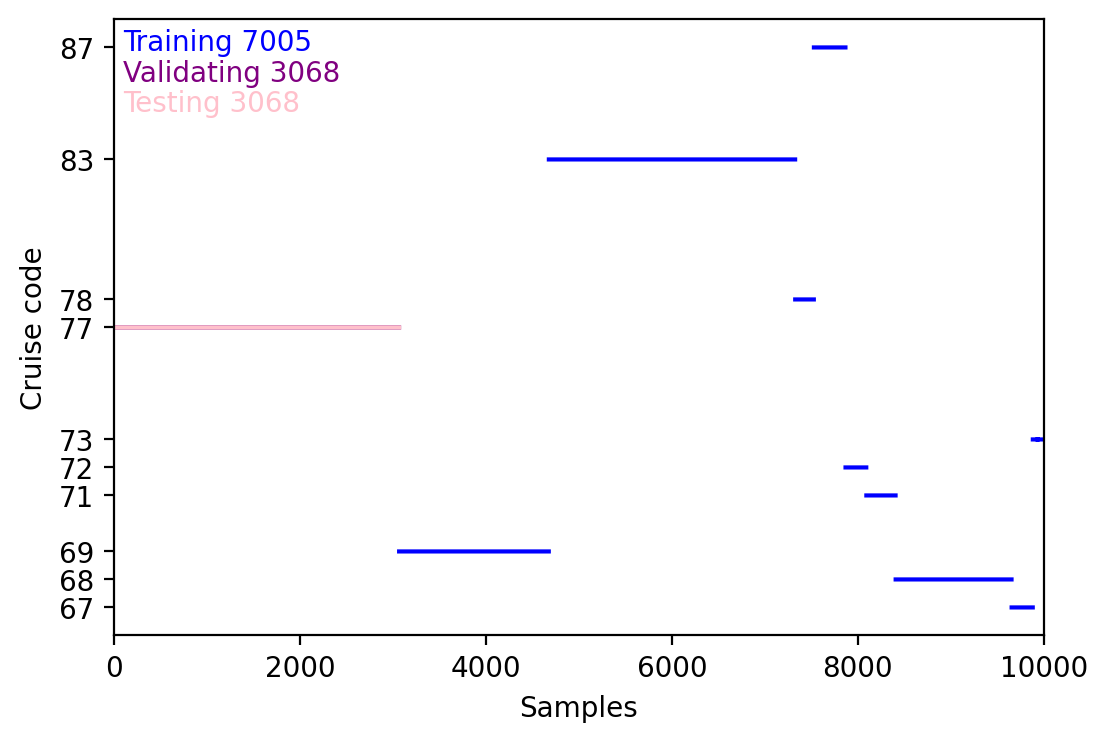

In [14]:
### This should not be necessary
model_reload.datasplit = split1
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=model_reload.datasplit, PLOT=True, XVIS='samples')
### But how do you record the weightfunc used in training 
def sample_weights(x):
    return np.where(x > 18, 10.0, 1.0)
training_data = RealFluxDataset(training_ds, weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, weightfunc=sample_weights)
testing_data = RealFluxDataset(testing_ds, weightfunc=sample_weights)

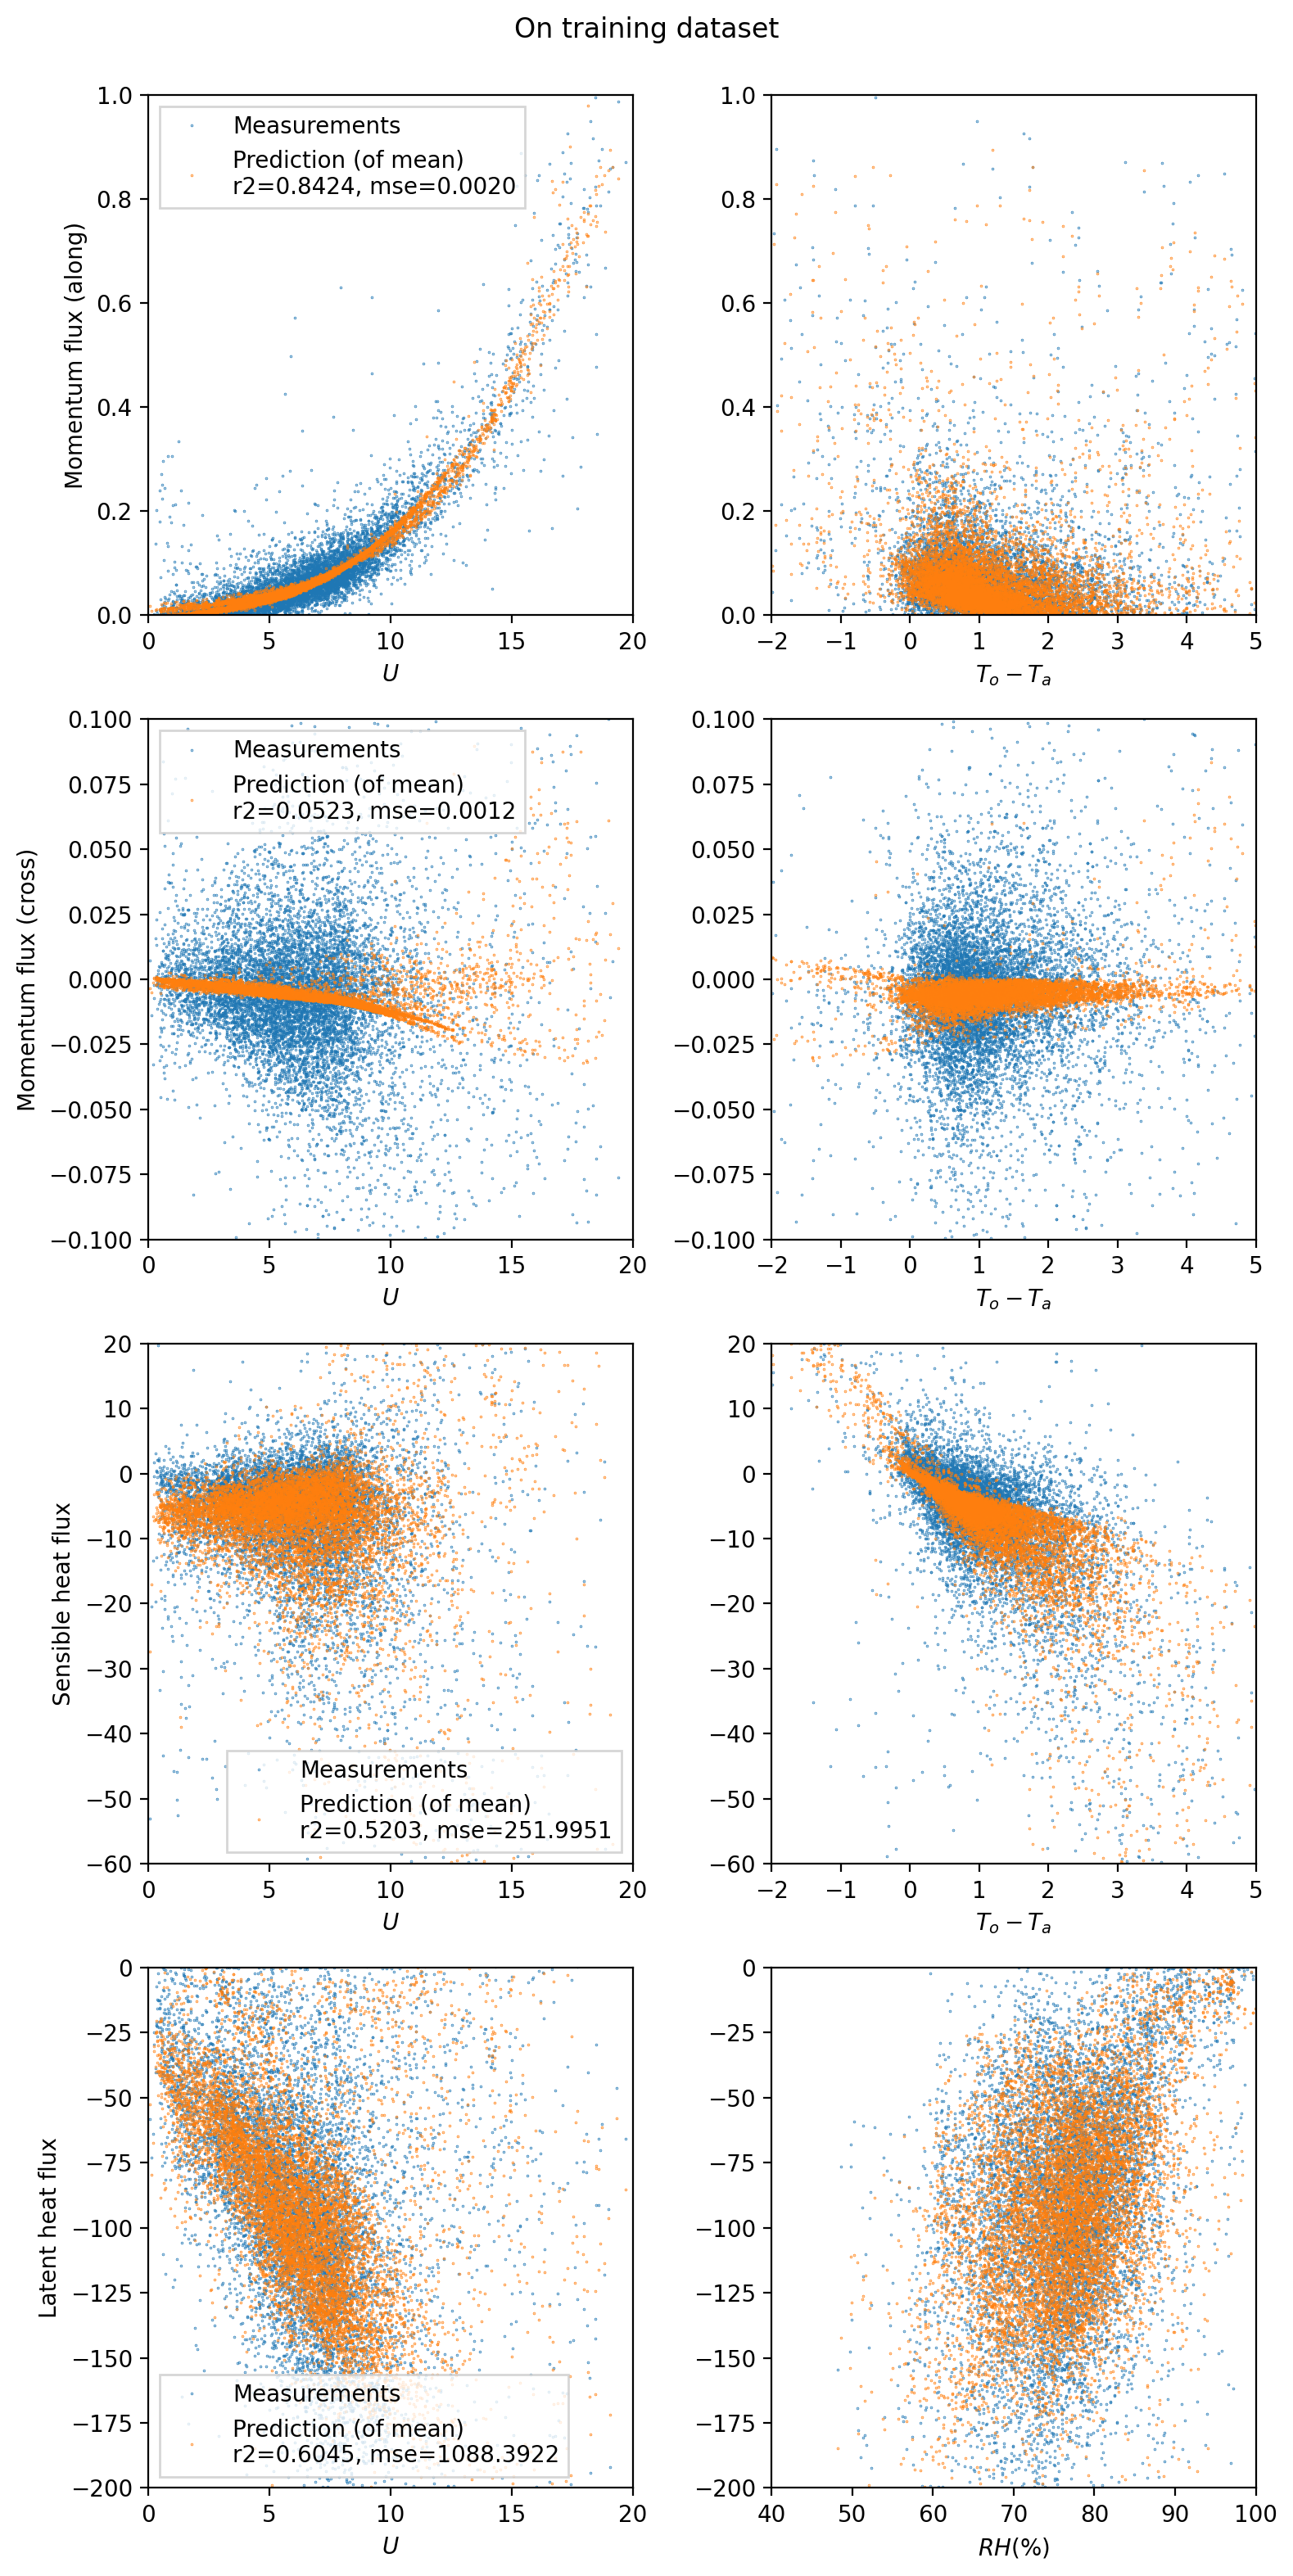

In [33]:
from mlflux.plotting import plotting_4features
fig = plotting_4features(model, training_data) # can change to training data
fig.suptitle('On training dataset')
fig.tight_layout(); fig.subplots_adjust(top=0.95)

In [91]:
bulk_keys = ['taubx','hsb','hlb']
for data,ds in zip((training_data, validating_data, testing_data),
                   (training_ds, validating_ds, testing_ds)):  
    data.Y_Bulk = torch.tensor(np.hstack([ds[key].values.reshape(-1,1) for key in bulk_keys]).astype('float32'))
    mse_bulk = []; r2_bulk = []
    for i in range(len(bulk_keys)):
        mse = torch.mean((data.Y[:,i]-data.Y_Bulk[:,i])**2)
        r2 = 1 - mse/torch.var(data.Y[:,i])
        mse_bulk.append(mse); r2_bulk.append(r2)
    data.mse_bulk = np.array(mse_bulk); data.r2_bulk = np.array(r2_bulk)

In [98]:
data = validating_data
print('Bulk r2 %.4f, mse %.4f' %(data.r2_bulk[0], data.mse_bulk[0]))

Bulk r2 0.8784, mse 0.0012
